<a href="https://colab.research.google.com/github/oreon36/Sentimientos/blob/main/analisis_componentes_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 4 — Análisis PCA (Ames Housing)
**Autor:** Héctor A. López G.  

**Fecha:** 2025-10-01 00:04

**Objetivo:** Realizar un **PCA** (Análisis de Componentes Principales) sobre columnas específicas del dataset Ames,
reemplazando valores faltantes por la **media**, **estandarizando** con `StandardScaler`, y ajustando un modelo con **`n_components = 16`**.


## 1) Librerías y carga de datos
- Usaremos `pandas` para manipulación de datos.
- `SimpleImputer` con estrategia **mean** (media) para completar faltantes.
- `StandardScaler` para normalizar variables.
- `PCA` con **16 componentes**.

In [80]:
# --- CELDA 2: Carga y exploración inicial del dataset ---
# Cargar dataset
import pandas as pd
df = pd.read_csv("train.csv")

print("=== INFORMACIÓN DEL DATASET ===")
print(f"Dimensiones: {df.shape}")
print(f"Columnas: {len(df.columns)}")
print("\nPrimeras 5 filas:")
display(df.head())

=== INFORMACIÓN DEL DATASET ===
Dimensiones: (1460, 81)
Columnas: 81

Primeras 5 filas:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [81]:

# CELDA 3 : SELECCIÓN ROBUSTA DE COLUMNAS PARA PCA
print("=== SELECCIÓN Y VALIDACIÓN DE COLUMNAS PARA PCA ===")
# 1️ Lista original de columnas que queremos usar (propuesta inicial)
columnas_deseadas = [
    'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea'
]

# Revisamos cuáles de esas columnas existen realmente en el dataset
columnas_existentes = [col for col in columnas_deseadas if col in df.columns]
columnas_faltantes = [col for col in columnas_deseadas if col not in df.columns]

print(f"Columnas encontradas: {len(columnas_existentes)}/{len(columnas_deseadas)}")
if columnas_faltantes:
    print(f"Columnas faltantes: {columnas_faltantes}")
else:
    print("Todas las columnas deseadas están presentes.")

# Si faltan columnas, agregamos otras numéricas para completar
if columnas_faltantes:
    print("\nCompletando columnas faltantes con otras numéricas disponibles...")
    columnas_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Quitamos columnas irrelevantes (ID y target)
    excluir = ['Id', 'SalePrice', 'MoSold', 'YrSold']
    columnas_numericas = [col for col in columnas_numericas if col not in excluir and col not in columnas_existentes]

    # Tomamos columnas adicionales para reemplazar las faltantes
    columnas_adicionales = columnas_numericas[:len(columnas_faltantes)]
    columnas_existentes += columnas_adicionales

    print(f"Columnas adicionales agregadas: {columnas_adicionales}")

#Forzamos que el total final sea exactamente 16 columnas (requisito consigna)
#columnas_seleccionadas = columnas_existentes[:16]
columnas_seleccionadas = columnas_existentes[:16]
df_pca = df[columnas_seleccionadas].copy()


print(f"\nNúmero final de columnas seleccionadas: {len(columnas_seleccionadas)}")
print("Columnas usadas en el PCA:")
for i, col in enumerate(columnas_seleccionadas, 1):
    print(f"{i:2d}. {col}")

# Creamos un nuevo DataFrame solo con esas columnas
df_pca = df[columnas_seleccionadas].copy()
print(f"\nDimensiones del subset para PCA: {df_pca.shape}")


=== SELECCIÓN Y VALIDACIÓN DE COLUMNAS PARA PCA ===
Columnas encontradas: 20/20
Todas las columnas deseadas están presentes.

Número final de columnas seleccionadas: 16
Columnas usadas en el PCA:
 1. LotFrontage
 2. LotArea
 3. OverallQual
 4. OverallCond
 5. YearBuilt
 6. YearRemodAdd
 7. MasVnrArea
 8. BsmtFinSF1
 9. BsmtFinSF2
10. BsmtUnfSF
11. TotalBsmtSF
12. 1stFlrSF
13. 2ndFlrSF
14. GrLivArea
15. GarageArea
16. WoodDeckSF

Dimensiones del subset para PCA: (1460, 16)


In [82]:
# --- CELDA 4: Manejo de valores faltantes ---
# Según consigna: "reemplazan los valores faltantes con la media"
from sklearn.impute import SimpleImputer

print("\n=== MANEJO DE VALORES FALTANTES ===")
print("Valores nulos antes de imputar:")
print(df_pca.isnull().sum())

#Creamos el imputador y lo ajustamos a la media
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(
    imputer.fit_transform(df_pca),
    columns=df_pca.columns,
    index=df_pca.index
)

print(f"\nValores nulos después de imputar: {df_imputed.isnull().sum().sum()}")
print("Todos los valores faltantes han sido reemplazados por la media.")



=== MANEJO DE VALORES FALTANTES ===
Valores nulos antes de imputar:
LotFrontage     259
LotArea           0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
MasVnrArea        8
BsmtFinSF1        0
BsmtFinSF2        0
BsmtUnfSF         0
TotalBsmtSF       0
1stFlrSF          0
2ndFlrSF          0
GrLivArea         0
GarageArea        0
WoodDeckSF        0
dtype: int64

Valores nulos después de imputar: 0
Todos los valores faltantes han sido reemplazados por la media.


In [83]:
# --- CELDA 5: Estandarización de datos ---
# Según consigna: "los datos se normalizan mediante la estandarización (con la clase StandardScaler)"
from sklearn.preprocessing import StandardScaler

print("\n=== ESTANDARIZACIÓN DE DATOS ===")

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)
df_scaled = pd.DataFrame(df_scaled, columns=df_imputed.columns)

print("Estadísticas después de estandarizar:")
print(df_scaled.describe().round(2))
print("\n Datos con media ~0 y desviación ~1 (necesario para PCA).")



=== ESTANDARIZACIÓN DE DATOS ===
Estadísticas después de estandarizar:
       LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
count      1460.00  1460.00      1460.00      1460.00    1460.00   
mean          0.00    -0.00         0.00         0.00       0.00   
std           1.00     1.00         1.00         1.00       1.00   
min          -2.23    -0.92        -3.69        -4.11      -3.29   
25%          -0.46    -0.30        -0.80        -0.52      -0.57   
50%           0.00    -0.10        -0.07        -0.52       0.06   
75%           0.41     0.11         0.65         0.38       0.95   
max          11.03    20.52         2.82         3.08       1.28   

       YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
count       1460.00     1460.00     1460.00     1460.00    1460.00   
mean           0.00       -0.00       -0.00       -0.00      -0.00   
std            1.00        1.00        1.00        1.00       1.00   
min           -1.69       -0.57    

In [84]:
# --- CELDA 6: Análisis PCA con 16 componentes ---
# Según consigna: "El modelo PCA se ajusta con n_components=16"
from sklearn.decomposition import PCA

print("\n=== ANÁLISIS PCA ===")

# Ajustamos PCA con 16 componentes
pca = PCA(n_components=16)
componentes_principales = pca.fit_transform(df_scaled)

# DataFrame con los componentes
df_componentes = pd.DataFrame(
    componentes_principales,
    columns=[f'PC{i+1}' for i in range(16)]
)

print(f"Dimensiones de la matriz de componentes: {df_componentes.shape}")

#  Varianza individual y total
print("\nVarianza explicada por cada componente:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var*100:.2f}%")

print(f"\n Varianza total explicada por 16 PCs: {pca.explained_variance_ratio_.sum()*100:.2f}%")



=== ANÁLISIS PCA ===
Dimensiones de la matriz de componentes: (1460, 16)

Varianza explicada por cada componente:
PC1: 30.22%
PC2: 11.50%
PC3: 9.82%
PC4: 8.94%
PC5: 6.88%
PC6: 6.26%
PC7: 5.29%
PC8: 5.10%
PC9: 4.13%
PC10: 3.95%
PC11: 3.13%
PC12: 2.02%
PC13: 1.47%
PC14: 1.26%
PC15: 0.02%
PC16: 0.00%

 Varianza total explicada por 16 PCs: 100.00%


In [85]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_pca.columns,
    columns=[f'PC{i+1}' for i in range(16)]
)


=== ANÁLISIS DE VARIANZA ===


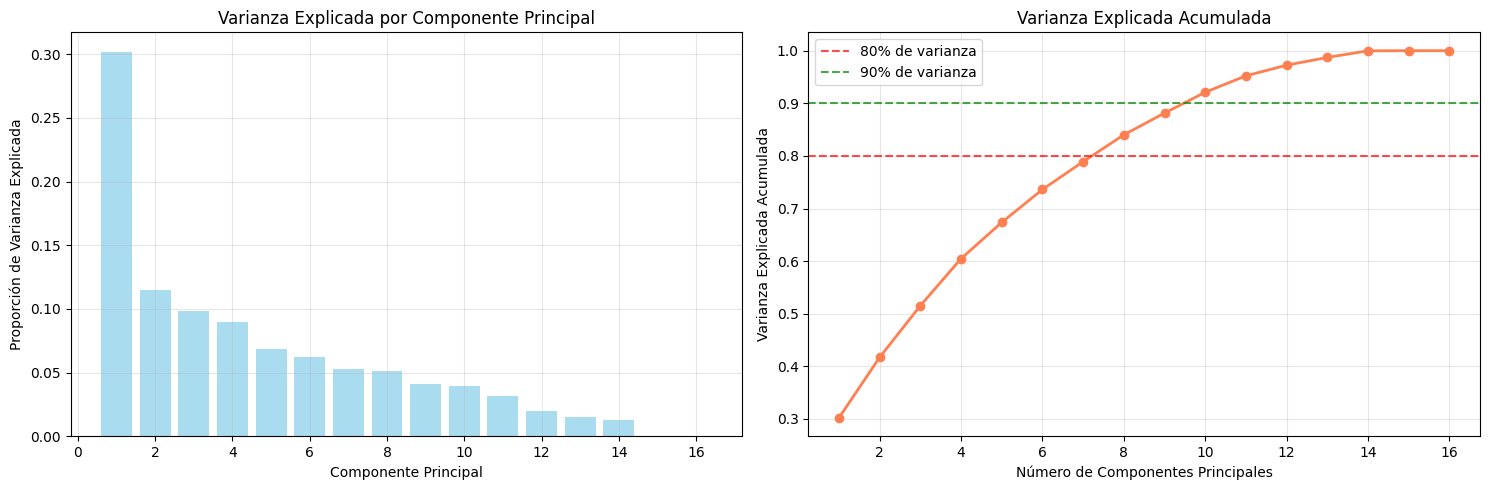

Varianza total explicada por 16 componentes: 1.0000 (100.00%)


In [86]:
# --- CELDA 7: Visualización de la varianza explicada ---
import numpy as np
import matplotlib.pyplot as plt

print("=== ANÁLISIS DE VARIANZA ===")

# Calcular varianza acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Crear visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Varianza individual
componentes = range(1, len(pca.explained_variance_ratio_) + 1)
ax1.bar(componentes, pca.explained_variance_ratio_, alpha=0.7, color='skyblue')
ax1.set_title('Varianza Explicada por Componente Principal')
ax1.set_xlabel('Componente Principal')
ax1.set_ylabel('Proporción de Varianza Explicada')
ax1.grid(True, alpha=0.3)

# Gráfico 2: Varianza acumulada
ax2.plot(componentes, varianza_acumulada, 'o-', linewidth=2, markersize=6, color='coral')
ax2.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% de varianza')
ax2.axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90% de varianza')
ax2.set_title('Varianza Explicada Acumulada')
ax2.set_xlabel('Número de Componentes Principales')
ax2.set_ylabel('Varianza Explicada Acumulada')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Varianza total explicada por 16 componentes: {varianza_acumulada[-1]:.4f} ({varianza_acumulada[-1]*100:.2f}%)")

=== INTERPRETACIÓN DE COMPONENTES ===
Cargas factoriales de los primeros 5 componentes:
                PC1    PC2    PC3    PC4    PC5
LotFrontage   0.216 -0.149  0.196  0.293 -0.100
LotArea       0.148 -0.239  0.317  0.216  0.021
OverallQual   0.363  0.216 -0.037 -0.107  0.111
OverallCond  -0.101  0.000  0.306 -0.020  0.626
YearBuilt     0.282  0.103 -0.341 -0.358 -0.025
YearRemodAdd  0.245  0.229 -0.159 -0.313  0.414
MasVnrArea    0.254  0.055  0.052 -0.087 -0.286
BsmtFinSF1    0.210 -0.447  0.139 -0.382 -0.204
BsmtFinSF2   -0.006 -0.264  0.142  0.058  0.394
BsmtUnfSF     0.149  0.314 -0.358  0.556  0.135
TotalBsmtSF   0.366 -0.245 -0.164  0.184  0.069
1stFlrSF      0.355 -0.268 -0.072  0.246  0.057
2ndFlrSF      0.088  0.504  0.509 -0.056 -0.148
GrLivArea     0.332  0.225  0.379  0.145 -0.081
GarageArea    0.335  0.033 -0.021 -0.072 -0.027
WoodDeckSF    0.172 -0.052  0.139 -0.201  0.280


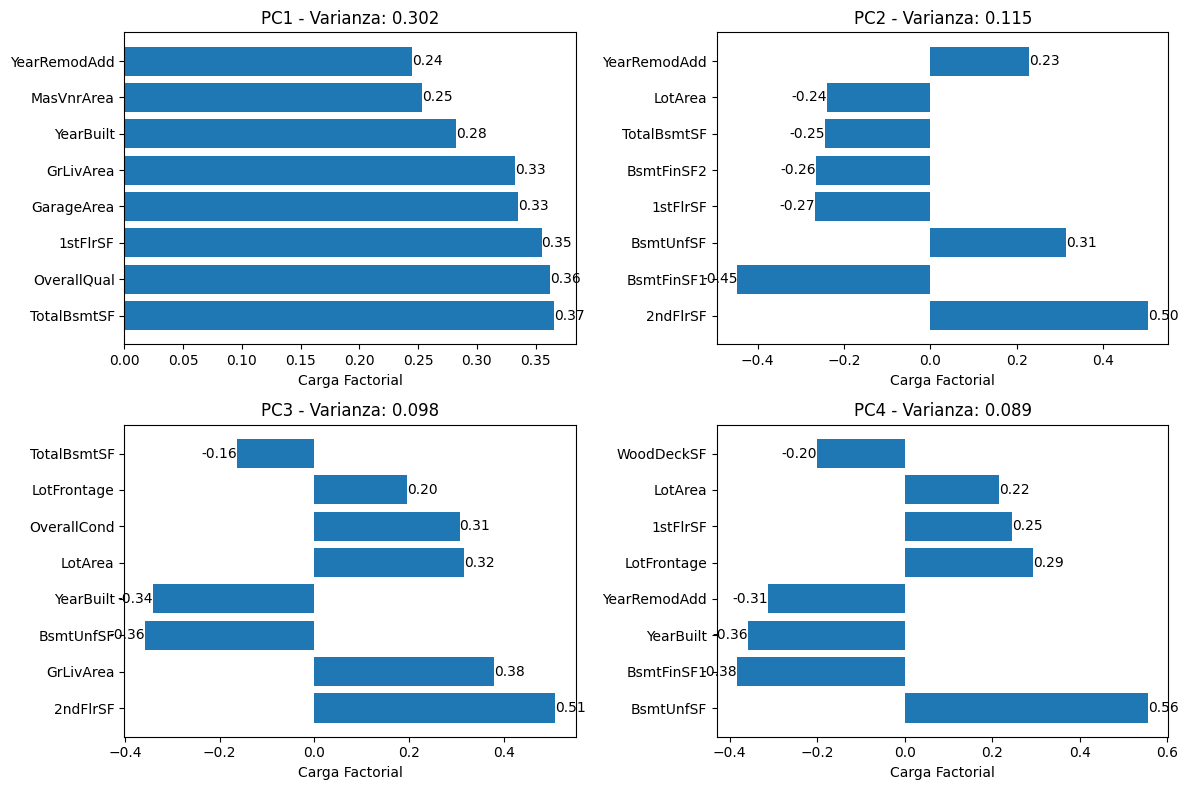

In [87]:
# --- CELDA 8: Interpretación de los componentes ---
print("=== INTERPRETACIÓN DE COMPONENTES ===")

# Crear DataFrame para las cargas factoriales
cargas_factoriales = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(16)],
    index=df_scaled.columns
)

print("Cargas factoriales de los primeros 5 componentes:")
print(cargas_factoriales.iloc[:, :5].round(3))

# Visualizar cargas factoriales para los primeros componentes
plt.figure(figsize=(12, 8))
componentes_a_mostrar = 4

for i in range(componentes_a_mostrar):
    plt.subplot(2, 2, i+1)

    # Ordenar características por importancia en el componente
    cargas_ordenadas = cargas_factoriales[f'PC{i+1}'].abs().sort_values(ascending=False)
    top_caracteristicas = cargas_ordenadas.head(8)

    # Graficar
    plt.barh(range(len(top_caracteristicas)),
             cargas_factoriales.loc[top_caracteristicas.index, f'PC{i+1}'])
    plt.yticks(range(len(top_caracteristicas)), top_caracteristicas.index)
    plt.title(f'PC{i+1} - Varianza: {pca.explained_variance_ratio_[i]:.3f}')
    plt.xlabel('Carga Factorial')

    # Añadir valores en las barras
    for j, valor in enumerate(cargas_factoriales.loc[top_caracteristicas.index, f'PC{i+1}']):
        plt.text(valor, j, f'{valor:.2f}', va='center', ha='left' if valor > 0 else 'right')

plt.tight_layout()
plt.show()

=== VISUALIZACIÓN EN ESPACIO REDUCIDO ===


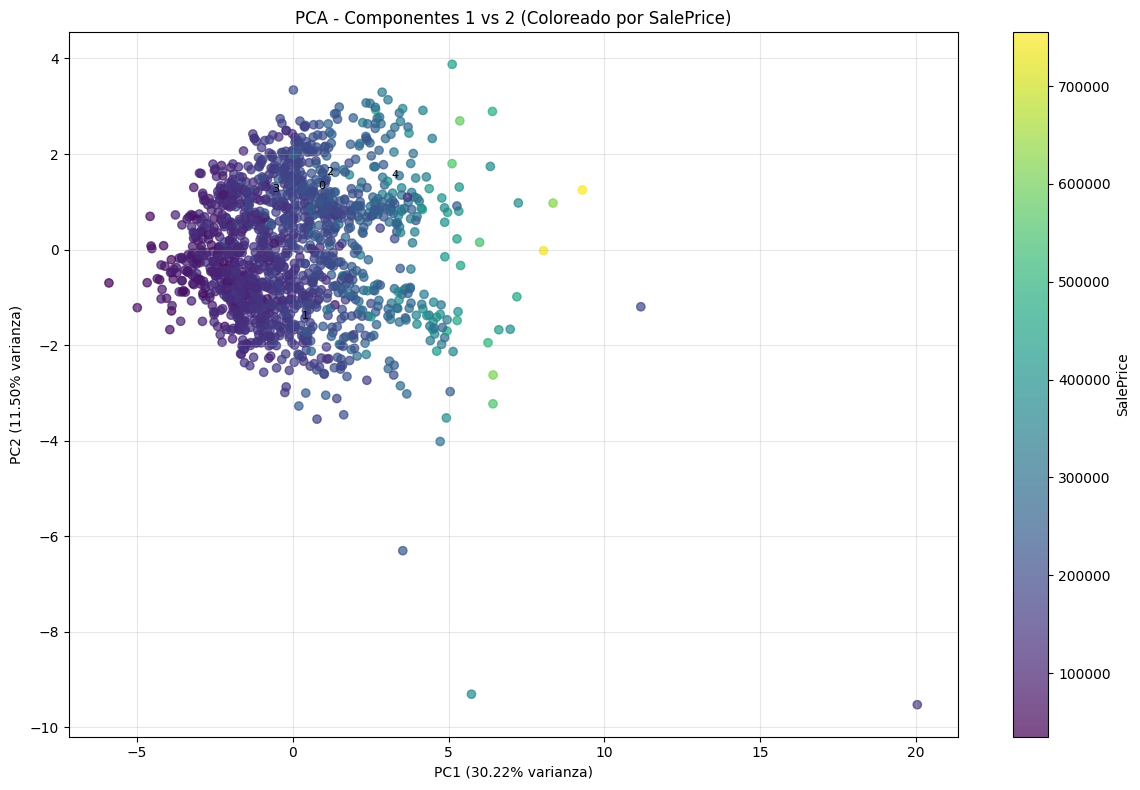

In [88]:
# --- CELDA 9: Visualización de datos en espacio reducido ---
print("=== VISUALIZACIÓN EN ESPACIO REDUCIDO ===")

# Crear scatter plot de los primeros dos componentes
plt.figure(figsize=(12, 8))

# Si tenemos SalePrice, podemos usarlo para colorear
if 'SalePrice' in df.columns:
    scatter = plt.scatter(df_componentes['PC1'], df_componentes['PC2'],
                         c=df['SalePrice'], cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='SalePrice')
    plt.title('PCA - Componentes 1 vs 2 (Coloreado por SalePrice)')
else:
    plt.scatter(df_componentes['PC1'], df_componentes['PC2'], alpha=0.7)
    plt.title('PCA - Componentes 1 vs 2')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% varianza)')
plt.grid(True, alpha=0.3)

# Añadir algunas anotaciones para puntos extremos
for i in range(min(5, len(df_componentes))):
    plt.annotate(f'{i}',
                (df_componentes['PC1'].iloc[i], df_componentes['PC2'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

=== CORRELACIÓN CON VARIABLE OBJETIVO ===
Correlación de componentes principales con SalePrice:
PC1: 0.8546
PC3: 0.1246
PC2: 0.1197
PC12: 0.0921
PC5: 0.0609
PC14: 0.0210
PC11: 0.0100
PC9: 0.0012
PC15: -0.0012
PC16: -0.0202
PC6: -0.0260
PC8: -0.0285
PC7: -0.0446
PC13: -0.0577
PC10: -0.0737
PC4: -0.0896


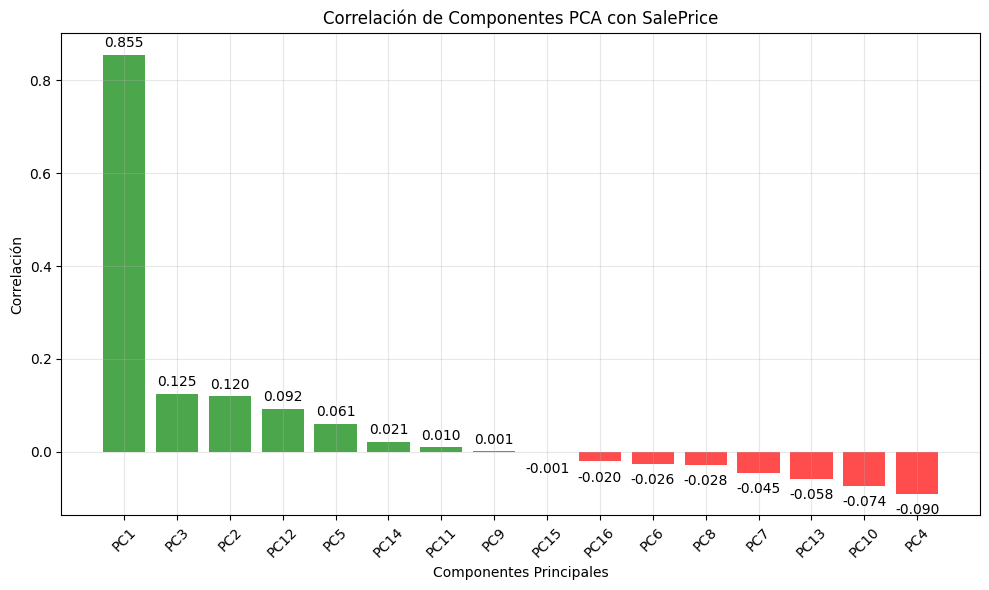

In [89]:
# --- CELDA 10: Análisis de correlación entre componentes y variables originales ---
print("=== CORRELACIÓN CON VARIABLE OBJETIVO ===")

if 'SalePrice' in df.columns:
    # Añadir SalePrice al DataFrame de componentes
    df_analisis = df_componentes.copy()
    df_analisis['SalePrice'] = df['SalePrice']

    # Calcular correlaciones
    correlaciones = df_analisis.corr()['SalePrice'].sort_values(ascending=False)

    print("Correlación de componentes principales con SalePrice:")
    for comp, corr in correlaciones.items():
        if comp != 'SalePrice':
            print(f"{comp}: {corr:.4f}")

    # Visualizar correlaciones
    plt.figure(figsize=(10, 6))
    componentes_corr = correlaciones.drop('SalePrice')
    colors = ['green' if x > 0 else 'red' for x in componentes_corr]

    plt.bar(componentes_corr.index, componentes_corr.values, color=colors, alpha=0.7)
    plt.title('Correlación de Componentes PCA con SalePrice')
    plt.xlabel('Componentes Principales')
    plt.ylabel('Correlación')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Añadir valores en las barras
    for i, (comp, corr) in enumerate(componentes_corr.items()):
        plt.text(i, corr + (0.01 if corr > 0 else -0.02), f'{corr:.3f}',
                ha='center', va='bottom' if corr > 0 else 'top')

    plt.tight_layout()
    plt.show()
else:
    print("SalePrice no disponible en el dataset para análisis de correlación")

In [90]:
# --- CELDA 11: Resumen ejecutivo y conclusiones ---
print("="*60)
print("RESUMEN EJECUTIVO - ANÁLISIS PCA")
print("="*60)

print(f" DATOS INICIALES:")
print(f"   • Columnas seleccionadas: {len(columnas_seleccionadas)}")
print(f"   • Instancias: {df_pca.shape[0]}")

print(f"\nRESULTADOS PCA:")
print(f"   • Componentes principales: 16")
print(f"   • Varianza total explicada: {varianza_acumulada[-1]*100:.2f}%")

# Encontrar número de componentes para 80% y 90% de varianza
comp_80 = np.where(varianza_acumulada >= 0.8)[0][0] + 1
comp_90 = np.where(varianza_acumulada >= 0.9)[0][0] + 1

print(f"   • Componentes para 80% de varianza: {comp_80}")
print(f"   • Componentes para 90% de varianza: {comp_90}")

print(f"\n INTERPRETACIÓN:")
print(f"   • PC1 explica: {pca.explained_variance_ratio_[0]*100:.2f}% de la varianza")
print(f"   • PC2 explica: {pca.explained_variance_ratio_[1]*100:.2f}% de la varianza")

if 'SalePrice' in df.columns:
    corr_pc1 = df_analisis.corr()['SalePrice']['PC1']
    print(f"   • Correlación PC1-SalePrice: {corr_pc1:.4f}")

print(f"\n RECOMENDACIONES:")
print(f"   • Considerar reducir a {comp_80} componentes para mantener 80% de varianza")
print(f"   • PC1 y PC2 son los más importantes para explicar la variabilidad")
print(f"   • Los componentes pueden usarse como input para modelos de ML")

print(f"\n✅ ANÁLISIS COMPLETADO")

RESUMEN EJECUTIVO - ANÁLISIS PCA
 DATOS INICIALES:
   • Columnas seleccionadas: 16
   • Instancias: 1460

RESULTADOS PCA:
   • Componentes principales: 16
   • Varianza total explicada: 100.00%
   • Componentes para 80% de varianza: 8
   • Componentes para 90% de varianza: 10

 INTERPRETACIÓN:
   • PC1 explica: 30.22% de la varianza
   • PC2 explica: 11.50% de la varianza
   • Correlación PC1-SalePrice: 0.8546

 RECOMENDACIONES:
   • Considerar reducir a 8 componentes para mantener 80% de varianza
   • PC1 y PC2 son los más importantes para explicar la variabilidad
   • Los componentes pueden usarse como input para modelos de ML

✅ ANÁLISIS COMPLETADO
